# Import packages

In [1]:
from ast import literal_eval
import numpy as np
import altair as alt
import pandas as pd
import geopandas as gpd
from datetime import timedelta
from scipy import stats
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt


from helper_functions import open_delays, open_processed_gtfs, create_timesteps

# alt.data_transformers.disable_max_rows()

# Notebook settings

In [2]:
AMOUNT_TO_TEST = 10

FIRST_TEST_SAMPLE_SIZE = 50
SECOND_TEST_SAMPLE_SIZE = 200

# Load in data

In [3]:
test = pd.read_csv(r'Intermediates\second_model_dist_test_data.csv')
test['data'] = [literal_eval(data_list) for data_list in test['data'].values]
test.head(5)

,Unnamed: 0,timestep,from_stop,to_stop,data
0,0,5.0,A01/C01,A02,"[-29, -54, -23, -40, -38, -53, -43, -56, -27, ..."
1,1,6.0,A01/C01,A02,"[-34, -31, -25, -22, -44, -50, -45, -42, -51, ..."
2,2,7.0,A01/C01,A02,"[-28, -45, 51, -48, -10, -41, -27, -38, -24, -..."
3,3,8.0,A01/C01,A02,"[-20, -18, 31, -44, -19, -44, 0, -45, -40, -4,..."
4,4,9.0,A01/C01,A02,"[-18, -43, -40, -39, -42, 2, -33, -36, -42, -2..."


# First test: most fitting dists

In [4]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names

# 'dgamma', 'dweibull', 'gennorm', 'laplace', 't', 'hypsecant', 'tukeylambda', 'laplace_asymmetric', 'logistic'

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        # print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Find best fit distribution
best_dist_counts = {}
count = 0
for _, row in test.iterrows():
    data = row['data']
    if len(data) < 100:
        continue

    print(count)

    best_distibutions = best_fit_distribution(data, 20)
    # print(best_distibutions)
    # best_dist = best_distibutions[0]

    # param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    # param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    # dist_str = '{}({})'.format(best_dist[0].name, param_str)

    for dist_index, points in zip([0, 1, 2], [3, 2, 1]):
        dist_str = best_distibutions[dist_index][0].name

        if dist_str not in best_dist_counts:
            best_dist_counts[dist_str] = 0

        best_dist_counts[dist_str] += points
    count += 1

    if count == 50:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [5]:
best_dicts = dict(sorted(best_dist_counts.items(), key=lambda item: item[1], reverse=True))
dist_list = list(best_dicts.keys())[0:AMOUNT_TO_TEST+1]
dist_list = [dist for dist in dist_list if dist != 'mielke']
print(f"Top {AMOUNT_TO_TEST} fitting distributions: {dist_list}")


Top 10 fitting distributions: ['exponnorm', 'invgamma', 'norminvgauss', 'nct', 'jf_skew_t', 'johnsonsu', 'genhyperbolic', 'betaprime', 'genlogistic', 'landau']


In [6]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names

# 'dgamma', 'dweibull', 'gennorm', 'laplace', 't', 'hypsecant', 'tukeylambda', 'laplace_asymmetric', 'logistic'

# dist_list = ['genhyperbolic', 'genlogistic', 'johnsonsu', 'norminvgauss', 'exponnorm', 'hypsecant', 'nct', 'laplace_asymmetric', 'logistic', 'jf_skew_t']

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if d in dist_list]):

        # print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

# Find best fit distribution
best_dist_sse = {dist: [] for dist in dist_list}
count = 0
for _, row in test.iterrows():
    data = row['data']
    if len(data) < 100:
        continue

    print(count)

    best_distibutions = best_fit_distribution(data, 20)

    for distribution in best_distibutions:
        best_dist_sse[distribution[0].name].append(distribution[2])

    count += 1

    if count == 200:
        break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


C:\Users\lange\AppData\Local\Temp\ipykernel_20520\692521900.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(best_dist_sse.values(),


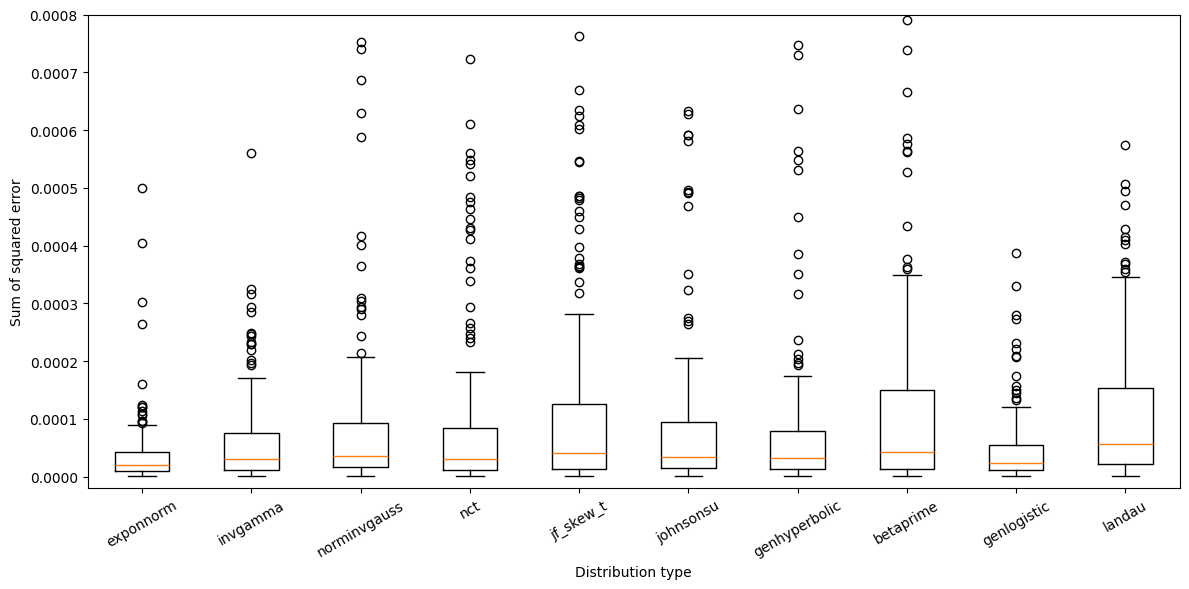

In [10]:
fig = plt.figure(figsize=(12,6))
# plt.hlines(np.median(best_dist_sse[list(best_dist_sse.keys())[0]]), xmin=0.5, xmax=10.5, color='red', linestyles='dashed', zorder=1)
plt.boxplot(best_dist_sse.values(),
            labels = best_dist_sse.keys(), zorder=2);
plt.xticks(rotation=30)
plt.ylim(-0.00002, 0.0008)

plt.ylabel("Sum of squared error")
plt.xlabel('Distribution type')

plt.tight_layout()

fig.savefig(r'Codebase figures\second_model_distributions_boxplot.png', dpi=300)

# plt.yscale('symlog')

  1 / 110: ksone
  2 / 110: kstwo
  3 / 110: kstwobign
  4 / 110: norm
  5 / 110: alpha
  6 / 110: anglit
  7 / 110: arcsine
  8 / 110: beta
  9 / 110: betaprime
 10 / 110: bradford
 11 / 110: burr
 12 / 110: burr12
 13 / 110: fisk
 14 / 110: cauchy
 15 / 110: chi
 16 / 110: chi2
 17 / 110: cosine
 18 / 110: dgamma
 19 / 110: dpareto_lognorm
 20 / 110: dweibull
 21 / 110: expon
 22 / 110: exponnorm
 23 / 110: exponweib
 24 / 110: exponpow
 25 / 110: fatiguelife
 26 / 110: foldcauchy
 27 / 110: f
 28 / 110: foldnorm
 29 / 110: weibull_min
 30 / 110: truncweibull_min
 31 / 110: weibull_max
 32 / 110: genlogistic
 33 / 110: genpareto
 34 / 110: genexpon
 35 / 110: genextreme
 36 / 110: gamma
 37 / 110: erlang
 38 / 110: gengamma
 39 / 110: genhalflogistic
 40 / 110: genhyperbolic
 41 / 110: gompertz
 42 / 110: gumbel_r
 43 / 110: gumbel_l
 44 / 110: halfcauchy
 45 / 110: halflogistic
 46 / 110: halfnorm
 47 / 110: hypsecant
 48 / 110: gausshyper
 49 / 110: invgamma
 50 / 110: invgauss
 51

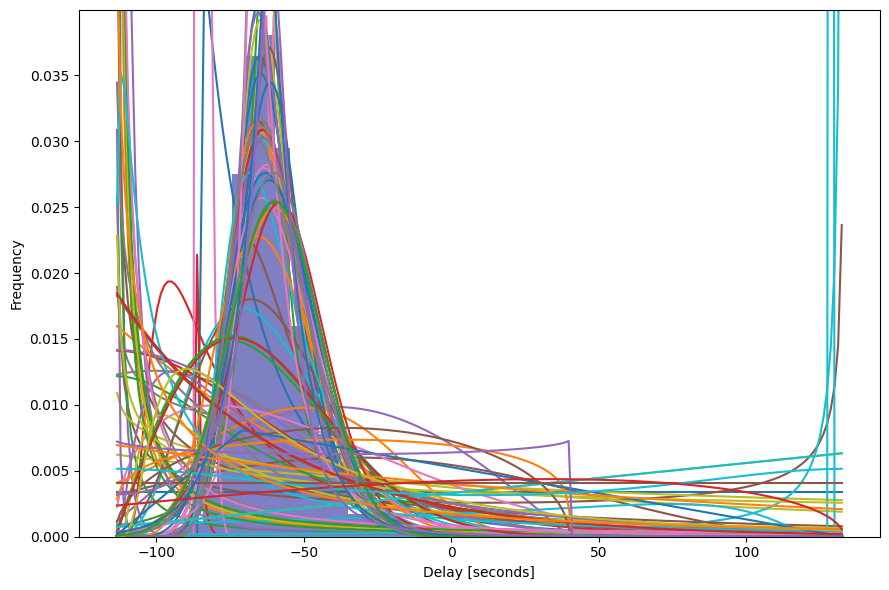

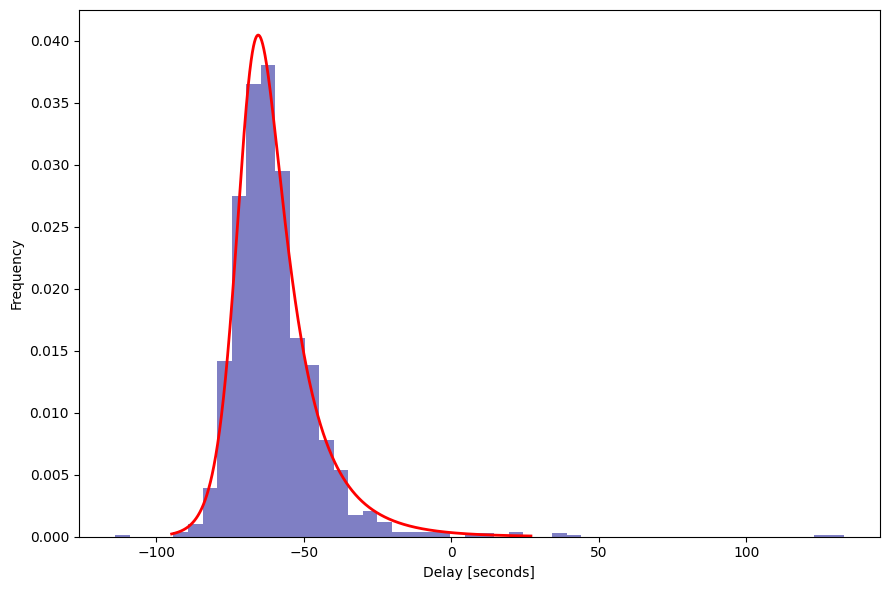

In [9]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
# matplotlib.style.use('ggplot')

# 'dgamma', 'dweibull', 'gennorm', 'laplace', 't', 'hypsecant', 'tukeylambda', 'laplace_asymmetric', 'logistic'

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.001, loc=loc, scale=scale)
    end = dist.ppf(0.999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.999, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
# data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
fig = plt.figure(figsize=(9,6))

single_test = test.iloc[891]['data']

plt.hist(single_test, bins=50, density=True, alpha=0.5, color='darkblue')

# ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

ax = fig.axes[0]

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(single_test, 200, ax)
print(best_distibutions)

for dist in best_distibutions:
    print(dist)
best_dist = best_distibutions[3]

# Update plots
ax.set_ylim(dataYLim)
# ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Delay [seconds]')
ax.set_ylabel('Frequency')

plt.tight_layout()

# fig.savefig(r'Codebase figures\all_distribution_test.png', dpi=300)


# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
fig = plt.figure(figsize=(9,6))

ax = pdf.plot(lw=2, label='PDF', color='red')

ax.hist(single_test, bins=50, density=True, alpha=0.5, label='Data', color='darkblue')

# data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

# ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Delay [seconds]')
ax.set_ylabel('Frequency')

plt.tight_layout()

fig.savefig(r'Codebase figures\second_model_winning_distribution.png', dpi=300)